<a href="https://colab.research.google.com/github/arunjegathesh/MLNS_Link_Prediction/blob/main/Link_prediction_main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
pip uninstall gensim

Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gensim-4.3.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gensim/*
Proceed (Y/n)? Y
  Successfully uninstalled gensim-4.3.1


In [ ]:
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26528023 sha256=0f487af509a222cccd4474b86074bb7cf34d358949fd72b96795b960ee255cc9
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.4.6 requires gensim<5.0.0,>=4.1.2, but you have gensim 3.8.3 which is incompatible.


In [ ]:
import gensim
print(gensim.__version__)

3.8.3


In [1]:
import os
import sys
import numpy as np 
import pandas as pd
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
# G = nx.from_pandas_edgelist(X[y == 1], 'node', 'target', create_using=nx.Graph())
        
# G.add_nodes_from(range(10496))

In [100]:
def CreateGraph (X, y, directed = False):
    
    if directed:
        G = nx.from_pandas_edgelist(X, 'node', 'target', create_using=nx.DiGraph())
    else:    
        G = nx.from_pandas_edgelist(X[y == 1], 'node', 'target', create_using=nx.Graph())
        
    G.add_nodes_from(range(10496))
    
    return G

In [5]:
G = CreateGraph(X, y)

In [ ]:
G

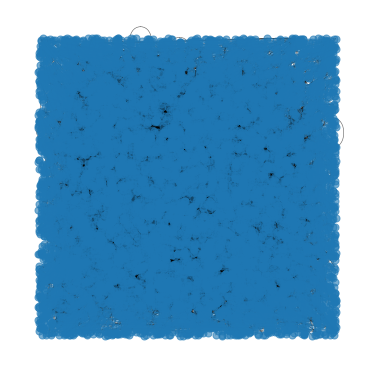

In [ ]:
# Plot graph
plt.figure(figsize=(5,5))

pos = nx.random_layout(G, seed=19)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)

plt.show()

In [101]:
def AppendNextworkxFeature (function, G, X):
    
    column_name = str(function).split()[1]
    
    tuple_list = list(X[['node','target']].itertuples(index=False, name=None))
    coef_generator = function(G, tuple_list)
    coef_df = pd.DataFrame(coef_generator)
    X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [102]:
def AppendNextworkxFeature_graphlevel (function, G, X):
    
    column_name = str(function).split()[1]
    
    coef_generator = function(G)
    X[column_name] = X['node'].map(coef_generator)

In [107]:
def nxGenerateFeatures(X_train, X_test, y_train):
    
    G = CreateGraph(X_train, y_train)

    # 1.3 Predict new coefficient/feature for defined link prediction function
    linkPredictionFunctions1 = [
        nx.resource_allocation_index,
        nx.jaccard_coefficient,
        nx.preferential_attachment]
    
    linkPredictionFunctions2 = [nx.degree_centrality,
                                nx.betweenness_centrality,
                                nx.closeness_centrality,
                                nx.eigenvector_centrality,
                                nx.clustering,
                                nx.pagerank,
                                nx.katz_centrality_numpy,
                                nx.average_neighbor_degree,
                                nx.triangles,
                                nx.average_clustering]

    for function in linkPredictionFunctions1:
        AppendNextworkxFeature(function, G, X_train)
        AppendNextworkxFeature(function, G, X_test)
    
    for function in linkPredictionFunctions2:
        AppendNextworkxFeature_graphlevel(function, G, X_train)
        AppendNextworkxFeature_graphlevel(function, G, X_test)

    return X_train, X_test


In [104]:
# def nxGenerateFeatures (X_train, X_test, y_train):
    
#     # 1.2 Create Graph
#     # Total number of nodes=pages: 33.226
#     G = CreateGraph (X_train, y_train)


#     # 1.3 Predict new coefficient/feature for defined link prediction function
#     linkPredictionFunctions = [nx.resource_allocation_index, nx.jaccard_coefficient, nx.preferential_attachment]#, nx.adamic_adar_index]
#     for function in linkPredictionFunctions:
#         AppendNextworkxFeature(function, G, X_train)
#         AppendNextworkxFeature(function, G, X_test)
        
#     return X_train, X_test

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [118]:
linkPredictionFunctions2 = [nx.degree_centrality,
                            nx.betweenness_centrality]
                            # nx.closeness_centrality,
                            # nx.eigenvector_centrality,
                            # nx.clustering,
                            # nx.pagerank,
                            # nx.katz_centrality_numpy,
                            # nx.average_neighbor_degree,
                            # nx.triangles,
                            # nx.average_clustering]

In [ ]:
for function in linkPredictionFunctions2:
        AppendNextworkxFeature_graphlevel(function, G, X_train)
        AppendNextworkxFeature_graphlevel(function, G, X_test)

In [117]:
X_train

,node,target,degree_centrality
4619,4616,7205,0.000191
10414,2921,4098,0.000191
9819,2827,5655,0.000286
2157,3236,6799,0.000286
3846,2909,4571,0.000095
...,...,...,...
5734,2954,3004,0.000095
5191,800,5171,0.000095
5390,609,2031,0.000095
860,2610,6516,0.000286


In [109]:
X_train, X_test = nxGenerateFeatures (X_train, X_test, y_train)

TypeError: ignored

In [ ]:
# tuple_list = list(X_train[['node','target']].itertuples(index=False, name=None))
# coef_generator = function(G, tuple_list)

In [ ]:
# coef_df = pd.DataFrame(coef_generator)
#     X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [82]:
tuple_list = list(X_train[['node','target']].itertuples(index=False, name=None))
coef_generator = nx.adamic_adar_index(G)

In [85]:
aa = nx.adamic_adar_index(G)

# create a dictionary to store the results
aa_dict = {}
for u, v, p in aa:
    aa_dict[(u, v)] = p

In [86]:
X_train['adamic_adar_index'] = X_train.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

In [93]:
X_train

,node,target
4619,4616,7205
10414,2921,4098
9819,2827,5655
2157,3236,6799
3846,2909,4571
...,...,...
5734,2954,3004
5191,800,5171
5390,609,2031
860,2610,6516


In [83]:
coef_generator

<generator object _apply_prediction.<locals>.<genexpr> at 0x7fc1a6269c80>

In [ ]:
coef_df = pd.DataFrame(coef_generator)

In [88]:
X_train.adamic_adar_index.unique()

array([0.        , 0.16981164, 0.37892318, 0.36067376, 0.36926937,
       0.30692768, 0.62133493, 0.48089835, 0.55811063, 1.44269504,
       0.72134752, 0.38987125, 0.30341308, 0.91023923, 0.28853901,
       0.34597626])

In [59]:
coef_df

""


In [52]:
X_train['ev'] = X_train['node'].map(coef_generator)

In [53]:
X_train

,node,target,preferential_attachment,jaccard_coefficient,resource_allocation_index,preferential_attachment,jaccard_coefficient,resource_allocation_index,degree_centrality,bw_centrality,cc,ev
4619,4616,7205,10,0.0,0.0,10,0.0,0.0,0.000191,0.000065,0.045584,3.305043e-07
10414,2921,4098,2,0.0,0.0,2,0.0,0.0,0.000191,0.000131,0.061367,5.224366e-05
9819,2827,5655,3,0.0,0.0,3,0.0,0.0,0.000286,0.000022,0.065861,2.332845e-03
2157,3236,6799,21,0.0,0.0,21,0.0,0.0,0.000286,0.000011,0.068255,2.736546e-03
3846,2909,4571,3,0.0,0.0,3,0.0,0.0,0.000095,0.000000,0.062364,1.941982e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2954,3004,2,0.0,0.0,2,0.0,0.0,0.000095,0.000000,0.046508,5.276268e-07
5191,800,5171,4,0.0,0.0,4,0.0,0.0,0.000095,0.000000,0.075987,3.676808e-02
5390,609,2031,1,0.0,0.0,1,0.0,0.0,0.000095,0.000000,0.056809,3.894350e-05
860,2610,6516,6,0.0,0.0,6,0.0,0.0,0.000286,0.000079,0.051264,1.819291e-05


In [ ]:
test = pd.DataFrame(dg)

In [36]:
print(coef_df)

         0     1   2
0     4616  7205  10
1     2921  4098   2
2     2827  5655   6
3     3236  6799  33
4     2909  4571   3
...    ...   ...  ..
8916  2954  3004   2
8917   800  5171   4
8918   609  2031   1
8919  2610  6516   6
8920  2024  3785  10

[8921 rows x 3 columns]


In [94]:
dg = nx.degree_centrality(G)

In [43]:
bw = nx.betweenness_centrality(G)

In [44]:
X_train['bw_centrality'] = X_train['node'].map(bw)

In [95]:
X_train['degree_centrality'] = X_train['node'].map(dg)

In [ ]:
import networkx as nx

In [ ]:
!pip uninstall gensim

Found existing installation: gensim 4.0.1
Uninstalling gensim-4.0.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gensim-4.0.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gensim/*
Proceed (Y/n)? Y
  Successfully uninstalled gensim-4.0.1


In [ ]:
import gensim
print(gensim.__version__)

4.3.1


In [ ]:
from sklearn.decomposition import PCA
from node2vec import Node2Vec

In [ ]:
# Create a Node2Vec object with parameters
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, p=0.5, q=2)

# Generate the node2vec embeddings


Computing transition probabilities:   0%|          | 0/10496 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


In [ ]:
model = node2vec.fit(window=10, min_count=1, workers=8, batch_words=4)

In [ ]:
model

In [ ]:
# Get the node2vec scores for each node
node_scores = {node: model.wv[str(node)] for node in list(G.nodes())}

# Sort the nodes based on their scores in descending order
top_nodes = sorted(node_scores, key=lambda x: np.linalg.norm(node_scores[x]), reverse=True)

# Print the top nodes
print("Top nodes:")
for node in top_nodes[:10]:
    print(node)


Top nodes:
1351
1467
4903
4434
4403
2326
2000
4098
7470
6418


In [ ]:
from gensim.models.doc2vec import similarity

In [ ]:
# WINDOW = 1 # Node2Vec fit window
# MIN_COUNT = 1 # Node2Vec min. count
# BATCH_WORDS = 4 # Node2Vec batch words

# g_emb = n2v(
#   G,
#   dimensions=16
# )

# mdl = g_emb.fit(
#     vector_size = 16,
#     window=WINDOW,
#     min_count=MIN_COUNT,
#     batch_words=BATCH_WORDS
# )

# input_node = '1'
# for s in mdl.wv.most_similar(input_node, topn = 10):
#     print(s)

In [ ]:
def XGB(LR = 0.0001, n_est = 10000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1, lambd = 0 , alpha = 0):
   
    xgb_model = XGBClassifier( learning_rate=LR, 
                                            n_estimators=n_est,
                                            max_depth=max_d,
                                            min_child_weight=min_c,                         
                                            gamma=gm,
                                            colsample_bytree=colsample,
                                            subsample=subs,
                                            objective ='binary:logistic',                   
                                            reg_lambda=lambd,
                                            reg_alpha=alpha,
                                            scale_pos_weight = 1,
                                            tree_method='gpu_hist',
                                            seed=42)


    xgb_model.fit(X_train,y_train)
    y_pred_train = xgb_model.predict(X_train)
    y_pred = xgb_model.predict(X_test)


    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))

In [ ]:
def XGB_tuning (LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1,
                lambd = 0, alpha = 0, param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate=LR, 
                                                    n_estimators=n_est,
                                                    max_depth=max_d,
                                                    min_child_weight=min_c,                         
                                                    gamma=gm,
                                                    colsample_bytree=colsample,
                                                    subsample = subs,
                                                    objective ='binary:logistic',
                                                    reg_lambda=lambd,
                                                    reg_alpha=alpha,
                                                    scale_pos_weight = 1,
                                                    tree_method='gpu_hist',
                                                    seed=42), 
                            param_grid = param_test, 
                            scoring='f1',
                            n_jobs=4, 
                            cv=3)


    gsearch.fit(X_train, y_train)
    return gsearch

In [ ]:
# STEP 1 - First XGB - A little bit overfitted, but could improve more the training set
LearningRate = 0.0001
n_estimators = 10000

# Fix Learning Rate and n_estimators
XGB(LearningRate, n_estimators)

performance over the training set: 0.7587472754387977
performance over the test set: 0.5640648011782032

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       783
           1       0.68      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.64      0.62      0.62      1575
weighted avg       0.64      0.62      0.62      1575



In [ ]:
# STEP 2 - Tuning max_depth and min_child_weight

parameters_test = {
    'max_depth':range(3,7,2),
    'min_child_weight':range(1,7,2)
}

gsearch2 = XGB_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_max_depth, best_min_child_weight = gsearch2.best_params_['max_depth'], gsearch2.best_params_['min_child_weight']
print(f"{gsearch2.best_params_} CV_Score: {gsearch2.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight)

{'max_depth': 5, 'min_child_weight': 3} CV_Score: 0.750496179904149
performance over the training set: 0.7588923647317808
performance over the test set: 0.5592841163310962

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       783
           1       0.68      0.47      0.56       792

    accuracy                           0.62      1575
   macro avg       0.64      0.63      0.62      1575
weighted avg       0.64      0.62      0.62      1575



In [ ]:
# STEP 3 - Tuning Gamma 
parameters_test = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}

gsearch3 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight,
                      param_test=parameters_test)
best_gamma = gsearch3.best_params_['gamma']
print(f"{gsearch3.best_params_} CV_Score: {gsearch3.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight, gm = best_gamma)

{'gamma': 0.1} CV_Score: 0.7505813147666659
performance over the training set: 0.7588923647317808
performance over the test set: 0.5592841163310962

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       783
           1       0.68      0.47      0.56       792

    accuracy                           0.62      1575
   macro avg       0.64      0.63      0.62      1575
weighted avg       0.64      0.62      0.62      1575



In [ ]:
# STEP 4 - Tuning colsample_bytree and subsaample
parameters_test = {
    'colsample_bytree':[i/10.0 for i in range(7,11)],
    'subsample':[i/10.0 for i in range(7,11)]
}

gsearch4 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                      gm = best_gamma, param_test=parameters_test)
best_colsample_bytree, best_subsample = gsearch4.best_params_['colsample_bytree'], gsearch4.best_params_['subsample']
print(f"{gsearch4.best_params_} CV_Score: {gsearch4.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample)

{'colsample_bytree': 1.0, 'subsample': 0.9} CV_Score: 0.7531659537824539
performance over the training set: 0.7624056711639606
performance over the test set: 0.5619469026548671

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       783
           1       0.68      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.62      1575
weighted avg       0.63      0.62      0.62      1575



In [ ]:
# STEP 5 - Tuning Regularization Parameters
# Lambda L2 Regularization
# Alpha L1 Regularization

parameters_test = {
    'reg_lambda':[1e-2, 0.1, 0.5, 1, 2, 10],
    'reg_alpha':[1e-2, 0.1, 0.5, 1, 2, 10],
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample, param_test=parameters_test)

best_reg_lambda, best_reg_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

{'reg_alpha': 10, 'reg_lambda': 10} CV_Score: 0.7559057400426378


In [ ]:
# Closer Look
parameters_test = {
    'reg_lambda':[best_reg_lambda*0.8, best_reg_lambda, best_reg_lambda*1.2, best_reg_lambda*1.5],
    'reg_alpha':[best_reg_alpha*0.8, best_reg_alpha, best_reg_alpha*1.2, best_reg_alpha*1.5]
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       param_test=parameters_test)

best_reg_lambda, best_red_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

{'reg_alpha': 8.0, 'reg_lambda': 8.0} CV_Score: 0.7561502075026358
performance over the training set: 0.7554782608695653
performance over the test set: 0.5529061102831595

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       783
           1       0.67      0.47      0.55       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.61      1575
weighted avg       0.63      0.62      0.61      1575



In [ ]:
 # STEP 6 - Reducing Learning Rate and Adding More Trees
n_estimators = 10000
parameters_test = {
    'learning_rate':[i/100.0 for i in range(1,10)]
}

gsearch6 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha, param_test=parameters_test)

LearningRate = gsearch6.best_params_['learning_rate']
print(f"{gsearch6.best_params_} CV_Score: {gsearch6.best_score_}")


# Final Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

{'learning_rate': 0.01} CV_Score: 0.7534381416839376
performance over the training set: 0.7708759954493742
performance over the test set: 0.5619469026548671

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       783
           1       0.68      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.62      1575
weighted avg       0.63      0.62      0.62      1575



In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [ ]:

X = X_train
y = y_train

In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/test.txt', header = None, 
                    sep = ' ', names = ['node', 'target'])
X_test = links[['node', 'target']]

In [ ]:
X, X_test = nxGenerateFeatures (X, X_test, y)
#X, X_test, y = nxGenerateFeatures(X, X_test, y)

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.01, 
                                        n_estimators=10000,
                                        max_depth=5,
                                        min_child_weight=3,                         
                                        gamma=0.1,
                                        colsample_bytree=1.0,
                                        subsample=0.9,
                                        objective ='binary:logistic',                   
                                        reg_lambda=8.0,
                                        reg_alpha=8.0,
                                        scale_pos_weight = 1,
                                        tree_method='gpu_hist',
                                        seed=42)


xgb_model.fit(X,y)
y_pred_train = xgb_model.predict(X)
y_pred = xgb_model.predict(X_test)


print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
#print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
#print(classification_report(y, y_pred))

performance over the training set: 0.7776635834189791


In [ ]:
# pd.DataFrame(y_pred, columns = ['predicted']).to_csv(result_file_name, sep=',', index=True, index_label='id')

In [ ]:
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])

In [ ]:
df_out = df_out.reset_index()
df_out = df_out.rename(columns={'index': 'ID'})

In [ ]:
df_out

In [ ]:
df_out.to_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/final_test_results_20230314_v1.csv', index=False)

In [ ]:
# Count the unique values in the "node" column of X_test
node_counts = X_test['node'].value_counts()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_test = nxGenerateFeatures (X_train, X_test, y_train)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:

def CatBoost(LR = 0.0001, n_est = 10000, max_d = 5, l2_val = 0.1, subs = 1):
   
    cb_model = CatBoostClassifier(learning_rate=LR,
                                   n_estimators=n_est,
                                   max_depth=max_d,
                                   reg_lambda=l2_val,
                                   subsample=subs,
                                   random_state=42)

    cb_model.fit(X_train,y_train, verbose=False)
    y_pred_train = cb_model.predict(X_train)
    y_pred = cb_model.predict(X_test)

    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))


In [ ]:
def CatBoost_tuning (LR = 0.1, n_est = 1000, max_d = 5, lambd = 0.1, subs = 0.8, 
                     param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = CatBoostClassifier(learning_rate=LR,
                                                          n_estimators=n_est,
                                                          max_depth=max_d,
                                                          reg_lambda=lambd,
                                                          subsample=subs,
                                                          random_state=42), 
                            param_grid = param_test, 
                            scoring='f1',
                            n_jobs=4, 
                            cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch


In [ ]:
# STEP 1 - First XGB - A little bit overfitted, but could improve more the training set
LearningRate = 0.0001
n_estimators = 1000

# Fix Learning Rate and n_estimators
CatBoost(LearningRate, n_estimators)

performance over the training set: 0.748204826368452
performance over the test set: 0.5569044006069803

              precision    recall  f1-score   support

           0       0.59      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 2 - Tuning max_depth

parameters_test = {
    'max_depth':[3,5,7,9]
}

gsearch2_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_max_depth = gsearch2_cb.best_params_['max_depth']
print(f"{gsearch2_cb.best_params_} CV_Score: {gsearch2_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth)

{'max_depth': 9} CV_Score: 0.748854879562472
performance over the training set: 0.7494712103407756
performance over the test set: 0.5575757575757576

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# # STEP 3 - l2_leaf tuning

# parameters_test = {
#     'l2_leaf_reg':[0.1, 1, 5, 10, 20]
# }

# gsearch3_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
# best_l2_leaf= gsearch3_cb.best_params_['l2_leaf_reg']
# print(f"{gsearch3_cb.best_params_} CV_Score: {gsearch3_cb.best_score_}")

# # Evaluation
# CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, l2_leaf_reg = best_l2_leaf)

In [ ]:
# STEP 4 - sub_sample tuning

parameters_test = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gsearch4_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_subsample= gsearch4_cb.best_params_['subsample']
print(f"{gsearch4_cb.best_params_} CV_Score: {gsearch4_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth,  subs = best_subsample)

{'subsample': 0.7} CV_Score: 0.7478623539302749
performance over the training set: 0.7494712103407756
performance over the test set: 0.5575757575757576

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 5 - lambda tuning

parameters_test = {'reg_lambda': [0.01, 0.1, 1, 10,100]}

gsearch5_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_reglambda= gsearch5_cb.best_params_['reg_lambda']
print(f"{gsearch5_cb.best_params_} CV_Score: {gsearch5_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'reg_lambda': 0.01} CV_Score: 0.7479693398271213
performance over the training set: 0.7503240249793803
performance over the test set: 0.5595147839272177

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.47      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 6 - LR tuning

parameters_test = {'learning_rate': [0.001, 0.01, 0.1, 1]}

gsearch6_cb = CatBoost_tuning (n_est = n_estimators, param_test=parameters_test)
best_lr= gsearch6_cb.best_params_['learning_rate']
print(f"{gsearch6_cb.best_params_} CV_Score: {gsearch6_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, n_est = n_estimators, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'learning_rate': 0.01} CV_Score: 0.7525625290022072
performance over the training set: 0.7750028772010589
performance over the test set: 0.5568685376661742

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       783
           1       0.67      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.61      1575
weighted avg       0.63      0.62      0.61      1575



In [ ]:
# STEP 7 - n_estimators tuning

parameters_test = {'n_estimators': [50, 100, 200, 500, 1000]}

gsearch7_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_est= gsearch7_cb.best_params_['n_estimators']
print(f"{gsearch7_cb.best_params_} CV_Score: {gsearch7_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, n_est = best_est, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'n_estimators': 10000} CV_Score: 0.751004047842959
performance over the training set: 0.9973045822102427
performance over the test set: 0.5558739255014327

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       783
           1       0.64      0.49      0.56       792

    accuracy                           0.61      1575
   macro avg       0.61      0.61      0.60      1575
weighted avg       0.61      0.61      0.60      1575



In [ ]:
# CatBoost(LR = best_lr, n_est = 1000, max_d=best_max_depth,
#         subs = best_subsample, l2_val = best_reglambda)

performance over the training set: 0.7750028772010589
performance over the test set: 0.5568685376661742

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       783
           1       0.67      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.61      1575
weighted avg       0.63      0.62      0.61      1575



In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/test.txt', header = None, 
                    sep = ' ', names = ['node', 'target'])
X_test = links[['node', 'target']]

In [ ]:
X = X_train
y = y_train

In [ ]:
X, X_test = nxGenerateFeatures (X, X_test, y)
#X, X_test, y = nxGenerateFeatures(X, X_test, y)

In [ ]:
cb_model = CatBoostClassifier(learning_rate=0.01,
                                   n_estimators=1000,
                                   max_depth=7,
                                   reg_lambda=0.1,
                                   subsample=0.9,
                                   random_state=42)

cb_model.fit(X,y, verbose=False)
y_pred_train = cb_model.predict(X)
y_pred = cb_model.predict(X_test)

print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
    # print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    # print(classification_report(y_test, y_pred))

performance over the training set: 0.7674552798615119


In [ ]:
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])

In [ ]:
df_out = df_out.reset_index()
df_out = df_out.rename(columns={'index': 'ID'})

In [ ]:
df_out.to_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/final_test_results_20230314_v4.csv', index=False)